# Thumbnail Search

In [1]:
# Imports
import cv2 as cv
import math
import numpy as np
from matplotlib import pyplot as plt

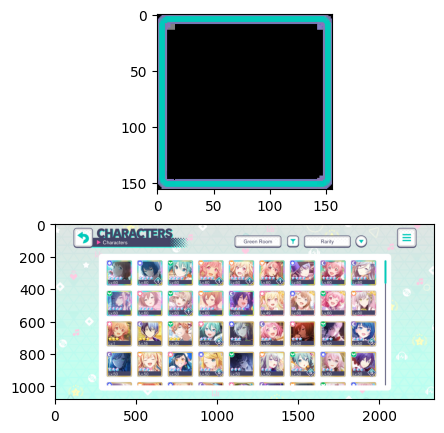

In [2]:
# Load images in BGR format
img_frame = cv.imread('./img/frame-1-blank.png')
img_list = cv.imread('../docs/character-list.jpg')

_, plots = plt.subplots(2, 1, figsize=(10, 5))
plots[0].imshow(img_frame[...,::-1])
plots[1].imshow(img_list[...,::-1])

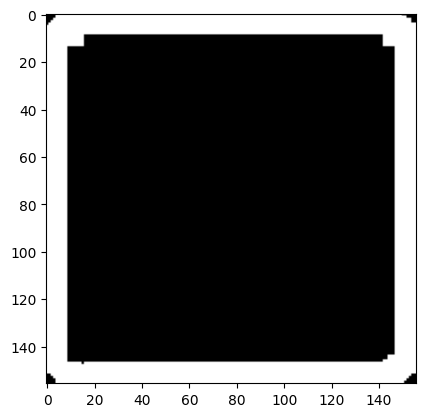

In [3]:
# Frame has a blank background which gets loaded in as black, so just threshold against this
img_frame_gray = cv.cvtColor(img_frame, cv.COLOR_BGR2GRAY)
_, img_frame_thresholded = cv.threshold(img_frame_gray, 0, 255, cv.THRESH_BINARY)
plt.imshow(img_frame_thresholded, cmap='gray')

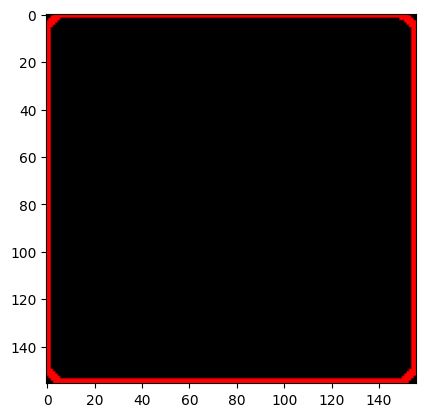

In [4]:
# Find contours in the frame, so we can use them later
img_frame_contours = np.zeros(img_frame.shape, dtype='B')
contours_frame, _ = cv.findContours(img_frame_thresholded.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_frame_contours, contours_frame, 0, (0, 0, 255), 2)

plt.imshow(img_frame_contours[..., ::-1])

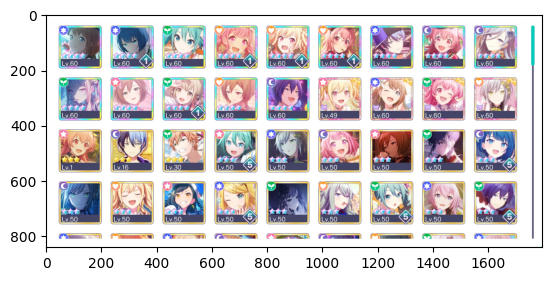

In [5]:
# Find the character box in the image
# This can be done by searching for the largest external contour
img_list_gray = cv.cvtColor(img_list, cv.COLOR_BGR2GRAY)
_, img_list_thresholded = cv.threshold(img_list_gray, 250, 255, cv.THRESH_BINARY)
contours_list, _ = cv.findContours(img_list_thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

contour_areas = [cv.contourArea(contour) for contour in contours_list]
contour_max_index = np.argmax(contour_areas)
max_contour = contours_list[contour_max_index]
max_contour_approx = cv.approxPolyDP(max_contour, 0.1 * cv.arcLength(max_contour, True), True)

x, y, w, h = cv.boundingRect(max_contour_approx)

img_box = img_list[y:y+h, x:x+w]
plt.imshow(img_box[..., ::-1])

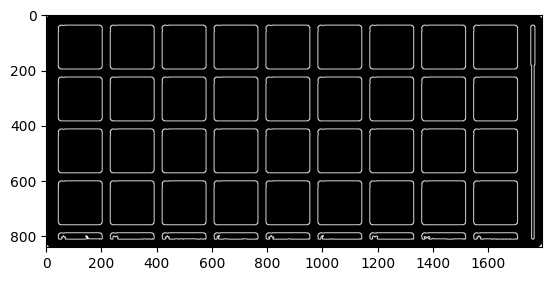

In [6]:
# Find contours within the character box
img_box_gray = img_list_gray[y:y+h, x:x+w]
img_box_gray_blurred = cv.GaussianBlur(img_box_gray, (5, 5), 0)
_, img_box_thresholded = cv.threshold(img_box_gray_blurred, 250, 255, cv.THRESH_BINARY_INV)
# plt.imshow(img_box_thresholded, cmap='gray')

# RETR_EXTERNAL seems to be the best option - it only finds the outer contours
img_box_contours = np.zeros(img_box_gray.shape, dtype='B')
contours_box, _ = cv.findContours(img_box_thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_box_contours, contours_box, -1, 255, 2)

plt.imshow(img_box_contours, cmap='gray')

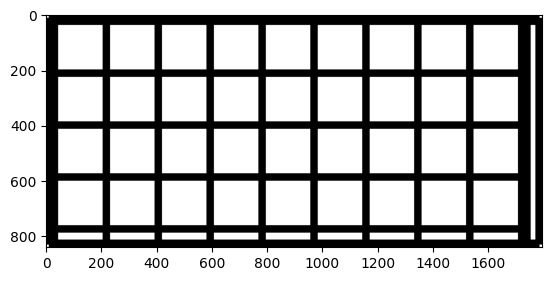

In [7]:
# The contours produced above are disjointed, so we can't use them directly
# To fix this, we can:
# - Draw the bounding rectangles for each contour
# - Find the external contours in this image
img_box_rects = np.zeros(img_box_gray.shape, dtype='B')
for contour_rect in contours_box:
    xb, yb, wb, hb = cv.boundingRect(contour_rect)
    cv.rectangle(img_box_rects, (xb, yb), (xb + wb, yb + hb), 255, -1)

plt.imshow(img_box_rects, cmap='gray')

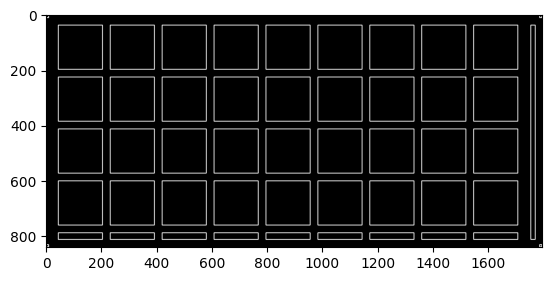

In [8]:
img_contours_rects = np.zeros(img_box_gray.shape, dtype='B')
contours_rects, _ = cv.findContours(img_box_rects, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_contours_rects, contours_rects, -1, 255, 2)

plt.imshow(img_contours_rects, cmap='gray')

[0.0012608535127895948, 0.006243623218790129, 0.001260853538840312, 0.001260853538840312, 0.001260853538840312, 0.001260853538865403, 0.001260853538865403, 0.001260853538865403, 0.0012608535388716202, 0.0012608535388716202, 0.0012608535388736186, 0.0012608535388465292, 0.0012608535388465292, 0.0012608535388465292, 0.0012608535388716202, 0.0012608535388716202, 0.0012608535388716202, 0.0012608535388780595, 0.0012608535388780595, 0.0012608535388798359, 0.0012608535388465292, 0.0012608535388465292, 0.0012608535388465292, 0.0012608535388716202, 0.0012608535388716202, 0.0012608535388716202, 0.0012608535388780595, 0.0012608535388780595, 0.0012608535388798359, 0.0012608535388485276, 0.0012608535388485276, 0.0012608535388485276, 0.0012608535388736186, 0.0012608535388736186, 0.0012608535388736186, 0.0012608535388798359, 0.0012608535388798359, 0.0012608535388818343, 0.006243623218790129, 0.0012608535388820563]
40
0.0012608535127895948
0.0015099920222093667
0.006243623218790129
[9, 10, 161, 161, 1

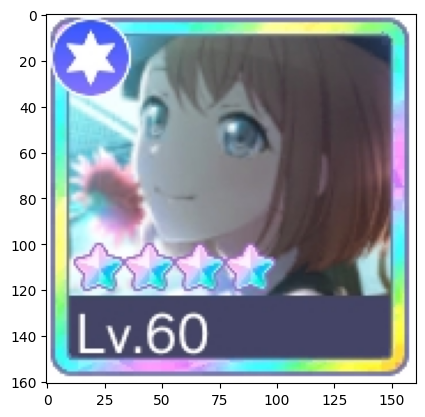

In [9]:
# Search for the frame's contour in the character box
# Should be viable now that the other 'rounded squares' are no longer present
# Based on the output from matchShapes, it looks like anything > 4 is probably a match
ret_values = []
card_bounding_boxes = []

for contour_rect in contours_rects:
    # NOTE: This assumes that the first contour in the frame is the largest one
    # Smaller moment value = closer match
    ret = cv.matchShapes(contours_frame[0], contour_rect, cv.CONTOURS_MATCH_I1, 0.0)
    
    if (ret < 1):
        ret_values.append(ret)

        card_bounding_box = cv.boundingRect(contour_rect)
        card_bounding_boxes.append(card_bounding_box)

print(ret_values)
print(len(ret_values))

print(np.min(ret_values))
print(np.average(ret_values))
print(np.max(ret_values))

# A lot of the matched shapes are too small
# So only consider ones with the right width
box_widths = [wb for (_, _, wb, _) in card_bounding_boxes]

print(box_widths)
print(np.min(box_widths))
print(np.average(box_widths))
print(np.max(box_widths))

card_bounding_boxes = np.array(card_bounding_boxes)
box_width_avg = np.average(card_bounding_boxes[:,2])
print(box_width_avg)

for (xb, yb, wb, hb) in card_bounding_boxes:
    if wb < box_width_avg:
        continue

    card_thumbnail = img_box[yb:yb+hb, xb:xb+wb]
    plt.imshow(card_thumbnail[..., ::-1])

[(44, 36, 161, 161), (232, 36, 161, 161), (420, 36, 161, 161), (608, 36, 161, 161), (796, 36, 161, 161), (984, 36, 161, 161), (1172, 36, 161, 161), (1360, 36, 161, 161), (1548, 36, 161, 161), (44, 224, 161, 161), (232, 224, 161, 161), (420, 224, 161, 161), (608, 224, 161, 161), (796, 224, 161, 161), (984, 224, 161, 161), (1172, 224, 161, 161), (1360, 224, 161, 161), (1548, 224, 161, 161), (44, 412, 161, 161), (232, 412, 161, 161), (420, 412, 161, 161), (608, 412, 161, 161), (796, 412, 161, 161), (984, 412, 161, 161), (1172, 412, 161, 161), (1360, 412, 161, 161), (1548, 412, 161, 161), (44, 600, 161, 161), (232, 600, 161, 161), (420, 600, 161, 161), (608, 600, 161, 161), (796, 600, 161, 161), (984, 600, 161, 161), (1172, 600, 161, 161), (1360, 600, 161, 161), (1548, 600, 161, 161)]


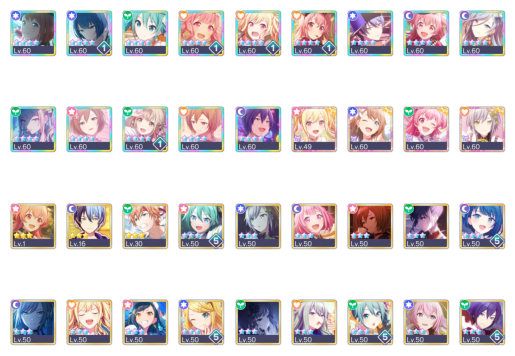

In [10]:
# Because we've joined up the contours into rectangles, we don't need to match against the frame anymore
# Instead, we can look for square-like rectangles - their width will be close to the maximum rectangle width
box_max_width = np.max(card_bounding_boxes[:, 2])
box_width_threshold = box_max_width * 0.9

thumb_bounding_boxes = [(xb, yb, wb, hb) for (xb, yb, wb, hb) in card_bounding_boxes if wb > box_width_threshold and hb > box_width_threshold]
thumb_bounding_boxes.reverse()
print(thumb_bounding_boxes)

# Determine number of rows and columns to display
cols = 9
rows = int(math.ceil(len(thumb_bounding_boxes) / cols))

fig, axes = plt.subplots(rows, cols)
thumbnails = []

for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        
        if index >= len(thumb_bounding_boxes):
            break

        (xb, yb, wb, hb) = thumb_bounding_boxes[index]
        thumbnail = img_box[yb:yb+hb, xb:xb+wb]

        axes[i, j].set_axis_off()
        axes[i, j].imshow(thumbnail[..., ::-1])

plt.show()